<a href="https://colab.research.google.com/github/Emmyeka1/Coursera_Capstone/blob/main/The_Battle_of_Neighborhoods_African_Rest_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IBM Applied Data Science Coursera Capstone Final Project**

# **Analyzing New York City Neighborhoods for the purpose of starting an African Restaurant**

# **By: Emmanuel Ekanem**

# **November 2020**

## **1. Import Python Libraries**

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline


print('Python Libraries imported.')

Python Libraries imported.


## **2. Download and Explore Dataset.**

## New York City has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

### Then, we will scrape data from wikipedia into a dataframe using BeautifulSoup package. The data source is https://en.wikipedia.org/wiki/New_York_City. This was used to get the population demographics of the five NYC boroughs.

In [2]:
response_obj = requests.get('https://en.wikipedia.org/wiki/New_York_City').text
soup = BeautifulSoup(response_obj,'html.parser')
#soup = BeautifulSoup(response_obj,'lxml')
Neighborhoods_NYC_Table = soup.find('table', {'class':'wikitable sortable'})

In [3]:
rows = Neighborhoods_NYC_Table.select("tbody > tr")[3:8]

boroughs = []
for row in rows:
    borough = {}
    tds = row.select('td')
    borough["borough"] = tds[0].text.strip()
    borough["county"] = tds[1].text.strip()
    borough["population"] = float(tds[2].text.strip().replace(",",""))
    borough["gdp_billions"] = float(tds[3].text.strip().replace(",",""))
    borough["gdp_per_capita"] = float(tds[4].text.strip().replace(",",""))
    borough["land_sqm"] = float(tds[5].text.strip().replace(",",""))
    borough["land_sqkm"] = float(tds[6].text.strip().replace(",",""))
    borough["persons_sqm"] = float(tds[7].text.strip().replace(",",""))
    borough["persons_sqkm"] = float(tds[8].text.strip().replace(",",""))
    
    boroughs.append(borough)

print(boroughs)

[{'borough': 'The Bronx', 'county': 'Bronx', 'population': 1418207.0, 'gdp_billions': 42.695, 'gdp_per_capita': 30100.0, 'land_sqm': 42.1, 'land_sqkm': 109.04, 'persons_sqm': 33867.0, 'persons_sqkm': 13006.0}, {'borough': 'Brooklyn', 'county': 'Kings', 'population': 2559903.0, 'gdp_billions': 91.559, 'gdp_per_capita': 35800.0, 'land_sqm': 70.82, 'land_sqkm': 183.42, 'persons_sqm': 36147.0, 'persons_sqkm': 13957.0}, {'borough': 'Manhattan', 'county': 'New York', 'population': 1628706.0, 'gdp_billions': 600.244, 'gdp_per_capita': 368500.0, 'land_sqm': 22.83, 'land_sqkm': 59.13, 'persons_sqm': 71341.0, 'persons_sqkm': 27544.0}, {'borough': 'Queens', 'county': 'Queens', 'population': 2253858.0, 'gdp_billions': 93.31, 'gdp_per_capita': 41400.0, 'land_sqm': 108.53, 'land_sqkm': 281.09, 'persons_sqm': 20767.0, 'persons_sqkm': 8018.0}, {'borough': 'Staten Island', 'county': 'Richmond', 'population': 476143.0, 'gdp_billions': 14.514, 'gdp_per_capita': 30500.0, 'land_sqm': 58.37, 'land_sqkm': 15

In [4]:
df = pd.DataFrame(boroughs, columns=["borough","county", "population", "gdp_per_capita", "persons_sqkm"]) 
df.head()

borough    county  population  gdp_per_capita  persons_sqkm
0      The Bronx     Bronx   1418207.0         30100.0       13006.0
1       Brooklyn     Kings   2559903.0         35800.0       13957.0
2      Manhattan  New York   1628706.0        368500.0       27544.0
3         Queens    Queens   2253858.0         41400.0        8018.0
4  Staten Island  Richmond    476143.0         30500.0        3150.0

### Use geopy library to get longitude and latitude coordinates.

In [5]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

### The Foursquare API platform was then used to extract and explore venue data. This dataset which contains venue recommendations for the boroughs and neighbourhoods in NYC was used to analyse African Restaurants in the different neighbourhoods and build the unsupervised learning model to cluster neighbourhoods. There was a limit of 100 venue recommendations per neighbourhood and a radius of 1000 meters around the geographical coordinates of each neighbourhood.

In [6]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'M22NS04LGY5MK1VP0Z4VVR3ESIYQUDCOK3ENDHPS10FFVTOP'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='04C4XWWNWI0FXJ4JRO034FUTF2PXWEHKRLVORUJ4NJIADYEY' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20201128' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results["response"]['groups'][0]['items']
    results['response'] 
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [7]:
def get_venue_details(venue_id):


    CLIENT_ID = 'M22NS04LGY5MK1VP0Z4VVR3ESIYQUDCOK3ENDHPS10FFVTOP'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='04C4XWWNWI0FXJ4JRO034FUTF2PXWEHKRLVORUJ4NJIADYEY' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20201128' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### The New York dataset was then used to get the geographical coordinates of NYC boroughs and neighbourhoods.

In [8]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [9]:
# get new york data
new_york_data=get_new_york_data()

In [10]:
new_york_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [11]:
new_york_data.shape

(306, 4)

### Matplotlib was used to visualize the number of neighbourhoods in NYC by Boroughs.

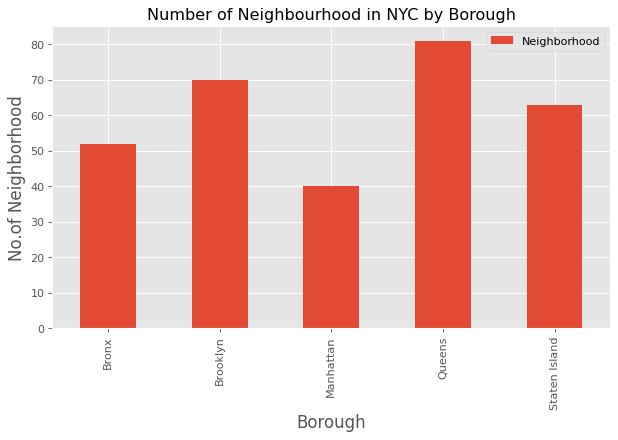

In [12]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

### We observed that Queens borough has the highest number of neighbourhoods in NYC (80), closely followed by Brooklyn, Staten Island, Bronx and Manhattan.

### Then we prepared a neighborhood list that contains African restaurant in NYC.


In [ ]:
# prepare neighborhood list that contains African restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
african_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    african_resturants=venues[venues['Category']=='African Restaurant']   
    print('(',count,'/',len(new_york_data),')','African Restaurants in '+Neighborhood+', '+Borough+':'+str(len(african_resturants)))
    for resturant_detail in african_resturants.values.tolist():
        id, name , category=resturant_detail
        african_rest_ny = african_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5fc1ed2092d28855b932bf4d'}, 'response': {'suggestedFilters': {'header': 'Tap to show:', 'filters': [{'name': '$-$$$$', 'key': 'price'}, {'name': 'Open now', 'key': 'openNow'}]}, 'headerLocation': 'Wakefield', 'headerFullLocation': 'Wakefield, Bronx', 'headerLocationGranularity': 'neighborhood', 'totalResults': 49, 'suggestedBounds': {'ne': {'lat': 40.903705185610015, 'lng': -73.83531662200086}, 'sw': {'lat': 40.88570516760999, 'lng': -73.85908441909719}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4c537892fd2ea593cb077a28', 'name': 'Lollipops Gelato', 'location': {'address': '4120 Baychester Ave', 'crossStreet': 'Edenwald & Bussing Ave', 'lat': 40.894123150205274, 'lng': -73.84589162362325, 'labeledLatLngs': [{'label': 'display', 'lat': 40.894123150205274, 'lng': -73.84

In [14]:
african_rest_ny.head()

Borough        Neighborhood                        ID               Name
0  Manhattan         Marble Hill  4ebde88d5c5c3d470bddd7e8            Lulu[s]
1      Bronx  University Heights  4c2f8b1b7cc0c9b6a1eaeb9a    Accra Resturant
2      Bronx  University Heights  4e9308c2b8f7cece23019981         Ebe Ye Yie
3      Bronx  University Heights  4cb2beaadedbef3bca7c9d40  Papaye Restaurant
4      Bronx             Fordham  4cb2beaadedbef3bca7c9d40  Papaye Restaurant

In [15]:
african_rest_ny.shape

(18, 4)

### Matplotlib was used to visualize the number of African Restaurants in NYC by Boroughs.

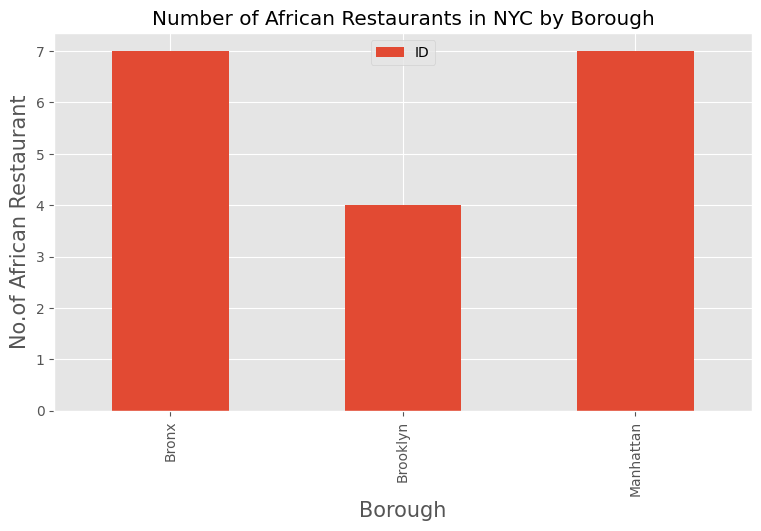

In [16]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of African Restaurants in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of African Restaurant', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### We observed that there were only 18 African Restauarants in NYC, and these were only in 3 boroughs; Bronx (7), Manhattan (7) and Brooklyn (4). This confirmed our earlier problem statement of the need for more African Restaurants in NYC; given that Queens and Staten Island had none.

### Though we noted that the Bronx and Manhattan has the highest number of African Restaurants, our analysis will focus on Central Harlem, Manhattan because it has 4 African Restaurants; the most for a neighbourhood in New York City.

In [17]:
african_rest_ny[african_rest_ny['Neighborhood']=='Central Harlem']

Borough    Neighborhood                        ID  \
9   Manhattan  Central Harlem  53e01975498e78c0915599bf   
10  Manhattan  Central Harlem  4c2fdced452620a120551e0f   
11  Manhattan  Central Harlem  5004a9e5e4b034c2950659fd   
12  Manhattan  Central Harlem  4a9ea132f964a520ad3a20e3   

                                Name  
9                Ponty Bistro Harlem  
10                       Keur Sokhna  
11  Les Ambassades Senegalais Bistro  
12            Africa Kine Restaurant

### Matplotlib was used to visualize the number of African Restaurants in NYC by Neighbourhoood.

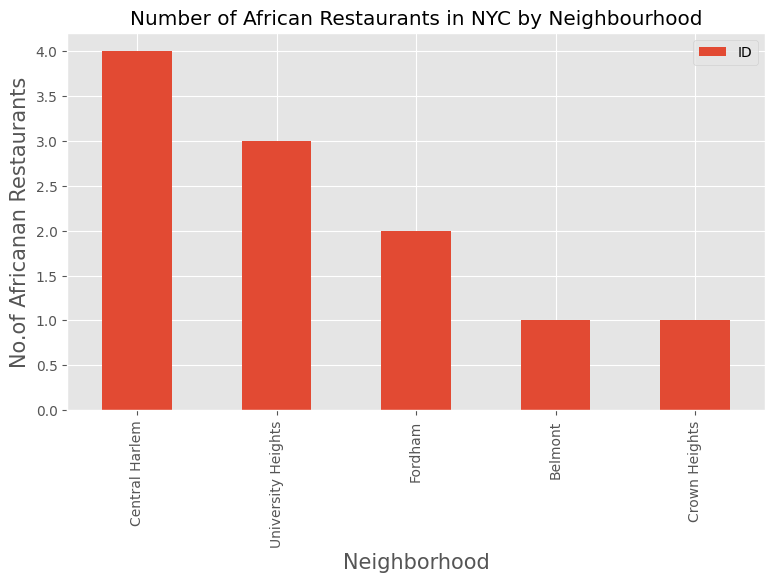

In [19]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of African Restaurants in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Africanan Restaurants', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

As earlier mentioned, Central Harlem, Manhattan has the most African Restaurants in New York City with a total count of 4. However, we will be preparing a list clustering only NYC boroughs and neighbourhoods that has an African Restaurant for further analysis.

In [20]:
# prepare neighborhood list that contains African Restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
african_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in african_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains African Restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
african_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in african_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID) # We will assign 0 value for these restaurants as they may have been recently opened or their details does not exist in the FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(african_rest_ny),')','processed')
    african_rest_stats_ny = african_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5fc1f03cadbbaf055501ce36'}, 'response': {'venue': {'id': '4ebde88d5c5c3d470bddd7e8', 'name': 'Lulu[s]', 'contact': {}, 'location': {'lat': 40.873293, 'lng': -73.900116, 'labeledLatLngs': [{'label': 'display', 'lat': 40.873293, 'lng': -73.900116}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lulus/4ebde88d5c5c3d470bddd7e8', 'categories': [{'id': '4bf58dd8d48988d1c8941735', 'name': 'African Restaurant', 'pluralName': 'African Restaurants', 'shortName': 'African', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/african_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok': False, 'allowMenuUrlEdit': True, 'beenHere': {'count': 0, 'uncon

In [21]:
african_rest_stats_ny.head()

Borough        Neighborhood                        ID               Name  \
0  Manhattan         Marble Hill                         0                  0   
1      Bronx  University Heights  4c2f8b1b7cc0c9b6a1eaeb9a    Accra Resturant   
2      Bronx  University Heights  4e9308c2b8f7cece23019981         Ebe Ye Yie   
3      Bronx  University Heights  4cb2beaadedbef3bca7c9d40  Papaye Restaurant   
4      Bronx             Fordham  4cb2beaadedbef3bca7c9d40  Papaye Restaurant   

  Likes Rating Tips  
0     0      0    0  
1     9    6.9    3  
2     7    7.5    2  
3    11    7.5    3  
4    11    7.5    3

In [22]:
african_rest_stats_ny.shape

(18, 7)

In [23]:
african_rest_stats_ny.to_csv('african_rest_stats_ny.csv', index=False)

In [24]:
african_rest_stats_ny_csv=pd.read_csv('african_rest_stats_ny.csv')

In [25]:
african_rest_stats_ny_csv.shape

(18, 7)

In [26]:
african_rest_stats_ny_csv.head()

Borough        Neighborhood                        ID               Name  \
0  Manhattan         Marble Hill                         0                  0   
1      Bronx  University Heights  4c2f8b1b7cc0c9b6a1eaeb9a    Accra Resturant   
2      Bronx  University Heights  4e9308c2b8f7cece23019981         Ebe Ye Yie   
3      Bronx  University Heights  4cb2beaadedbef3bca7c9d40  Papaye Restaurant   
4      Bronx             Fordham  4cb2beaadedbef3bca7c9d40  Papaye Restaurant   

   Likes  Rating  Tips  
0      0     0.0     0  
1      9     6.9     3  
2      7     7.5     2  
3     11     7.5     3  
4     11     7.5     3

In [27]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       18 non-null     object
 1   Neighborhood  18 non-null     object
 2   ID            18 non-null     object
 3   Name          18 non-null     object
 4   Likes         18 non-null     object
 5   Rating        18 non-null     object
 6   Tips          18 non-null     object
dtypes: object(7)
memory usage: 1.1+ KB


### Our analysis revealed that certain columns had object dtypes rather than float dtypes. So, we used pandas.Series.astype to convert Likes, Tips and rating object dtypes to float dtypes for ease of data analysis.

In [28]:
african_rest_stats_ny['Likes']=african_rest_stats_ny.Likes.astype(float)

In [29]:
african_rest_stats_ny['Tips']=african_rest_stats_ny.Tips.astype(float)

In [30]:
african_rest_stats_ny['Rating']=african_rest_stats_ny.Rating.astype(float)

In [31]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       18 non-null     object 
 1   Neighborhood  18 non-null     object 
 2   ID            18 non-null     object 
 3   Name          18 non-null     object 
 4   Likes         18 non-null     float64
 5   Rating        18 non-null     float64
 6   Tips          18 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.1+ KB


### Analyze African Restaurant in NYC with maximum Likes.

In [32]:
# African Restaurant with maximum Likes
african_rest_stats_ny.iloc[african_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                207
Rating                               8.6
Tips                                  59
Name: 7, dtype: object

### Analyze African Restaurant in NYC with maximum Tips.

In [33]:
# African Restaurant with maximum Tips
african_rest_stats_ny.iloc[african_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                207
Rating                               8.6
Tips                                  59
Name: 7, dtype: object

### Analyze African Restaurant in NYC with maximum Rating.

In [34]:
# African Restaurant with maximum Rating
african_rest_stats_ny.iloc[african_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                 East Harlem
ID              5b855d2da0215b002c09d9fa
Name                             Teranga
Likes                                 19
Rating                               8.8
Tips                                   7
Name: 13, dtype: object

### Our analysis revealed that though the African Restaurant with the maximum Likes and Tips is in Crown Heights< Brooklyn, the African Restaurant with the maximum Rating is in East Harlem Manahattan.

### Explore the average rating for African Restaurants in NYC Neighbourhoods.

In [35]:
ny_neighborhood_stats=african_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [36]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
3          East Harlem             8.8
5     Hamilton Heights             8.7
2        Crown Heights             8.6
1       Central Harlem             7.7
0              Belmont             7.5
4              Fordham             7.5
10  University Heights             7.3
8           Mount Hope             6.9
9                Rugby             6.5
11             Wingate             6.5

### Explore the average rating for African Restaurants in NYC Boroughs.

In [37]:
ny_borough_stats=african_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [38]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
0      Bronx        7.328571
2  Manhattan        6.900000
1   Brooklyn        6.850000

### Visualize the average rating of African Restaurants in each NYC Borough.

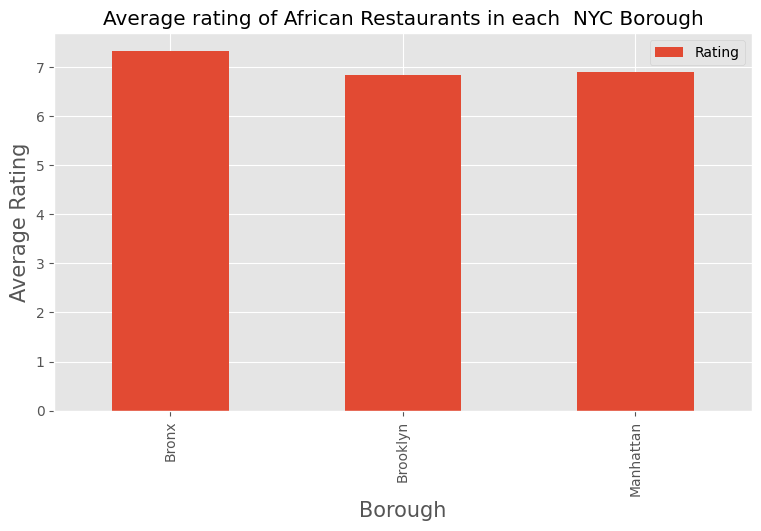

In [39]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of African Restaurants in each  NYC Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
african_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### We observe that the Bronx has the highest average rating for African Restaurants in NYC Boroughs.

### Next, we will filter all African Restaurants in NYC neighborhoods with ratings >= 7, and create a map to visualize them.

In [40]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [41]:
ny_neighborhood_stats

Neighborhood  Average Rating
0              Belmont             7.5
1       Central Harlem             7.7
2        Crown Heights             8.6
3          East Harlem             8.8
4              Fordham             7.5
5     Hamilton Heights             8.7
10  University Heights             7.3

Then, we will merge data and get the longitude and latitude coordinates to create a map.

In [42]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [43]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [44]:
# Create a table to view the dataframe
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Borough        Neighborhood   Latitude  Longitude  Average Rating
3  Manhattan         East Harlem  40.792249 -73.944182             8.8
5  Manhattan    Hamilton Heights  40.823604 -73.949688             8.7
2   Brooklyn       Crown Heights  40.670829 -73.943291             8.6
1  Manhattan      Central Harlem  40.815976 -73.943211             7.7
0      Bronx             Belmont  40.857277 -73.888452             7.5
4      Bronx             Fordham  40.860997 -73.896427             7.5
6      Bronx  University Heights  40.855727 -73.910416             7.3

In [45]:
# Create a folium map to display the merged dataframe. 
ny_map = folium.Map(location=(40.693943, -73.985880), zoom_start=12)

In [46]:
# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# Loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # Define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [47]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

### Visualize the neighbourhoods in New York City with the highest average rating for African Restaurants.

In [48]:
# Add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# Add incidents to map
ny_map.add_child(incidents)